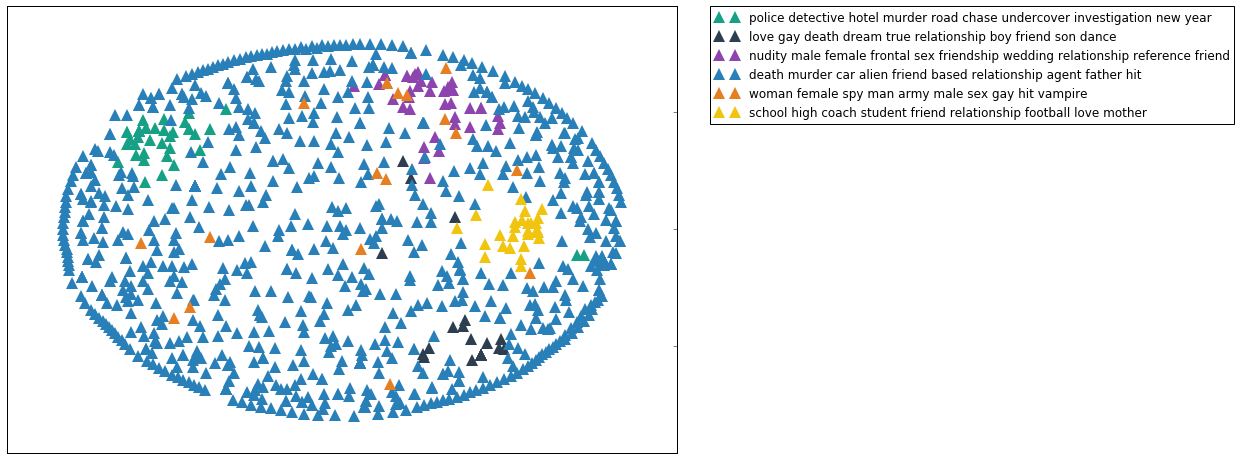

In [1]:
import nltk
from sklearn import feature_extraction
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS
import pandas as pd 
import re
import numpy as np
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

movie_df = pd.read_csv('movie_master_dataset.csv', encoding = "ISO-8859-1")

hg = movie_df.sort(['gross'], ascending = False)
hg = hg.reset_index(drop=True)
hg = hg.head(1000)

titles = list(hg['movie_title']) 
keywords = list(hg['plot_keywords'])
keywords = [key.replace('|', ' ') for key in keywords]

def unique_list(l):
    remove_list = ['box', 'office', 'flop', 'bashed', 'critically', 'title', 'word', 'character', 'scene', 'credits']
    ulist = []
    [ulist.append(x) for x in l if x not in ulist and x not in remove_list and not set('[~!@#$%^&*()_+{}":;\']+$').intersection(x)]
    return ulist

keywords = [' '.join(unique_list(key.split())) for key in keywords]

def tokenize(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,
                                 min_df=0.01, stop_words='english',
                                 use_idf=True, tokenizer=tokenize, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(keywords) 
terms = tfidf_vectorizer.get_feature_names() 

dist = 1 - cosine_similarity(tfidf_matrix)
k = 6

km = KMeans(n_clusters=k)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

#print("Top terms per cluster:")
asc_order_centroids = km.cluster_centers_.argsort()#[:, ::-1]
order_centroids = asc_order_centroids[:,::-1]
terms = tfidf_vectorizer.get_feature_names()
labels = [] 
for i in range(k):
    #print("Cluster {}:".format(i))
    temp = {i: []}
    for ind in order_centroids[i, :10]:
        temp[i].append(terms[ind])
        #print(' {}'.format(terms[ind]))
    #print('')
    labels.append(temp) 
    
words = ['', '', '', '', '', ''] 
index = 0 
for i in labels: 
    for j in i: 
        for k in range(len(i[j])): 
            if k == (len(i[j]) - 1): 
                words[index] += i[j][k]
            else: 
                words[index] += i[j][k] + ','
    index += 1 
    
clean_words = []
for word in words:
    word = word.replace(',', ' ')
    word = ' '.join(unique_list(word.split()))
    clean_words.append(word)
words = clean_words
    
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist) ;
xs, ys = pos[:, 0], pos[:, 1]

# set up colors per clusters using a dict
cluster_colors = {0: '#16a085', 1: '#2c3e50', 2: '#8e44ad', 3: '#2980b9', 4: '#e67e22', 5:'#f1c40f'} 

# set up cluster names using a dict
cluster_names = {0: words[0], 
                 1: words[1], 
                 2: words[2], 
                 3: words[3], 
                 4: words[4],
                 5: words[5]
                }

df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#cluster groups 
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 8)) 
ax.margins(0.10) 

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='^', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          
        which='both',      
        bottom='off',      
        top='off',         
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         
        which='both',      
        left='off',      
        top='off',         
        labelleft='off')
    
ax.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show() 

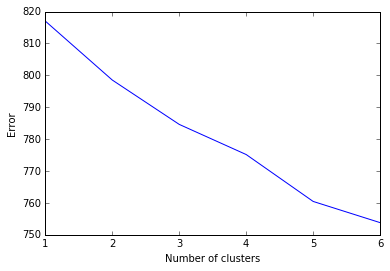

In [67]:
def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_

    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')
    
evaluate_clusters(tfidf_matrix, 6)

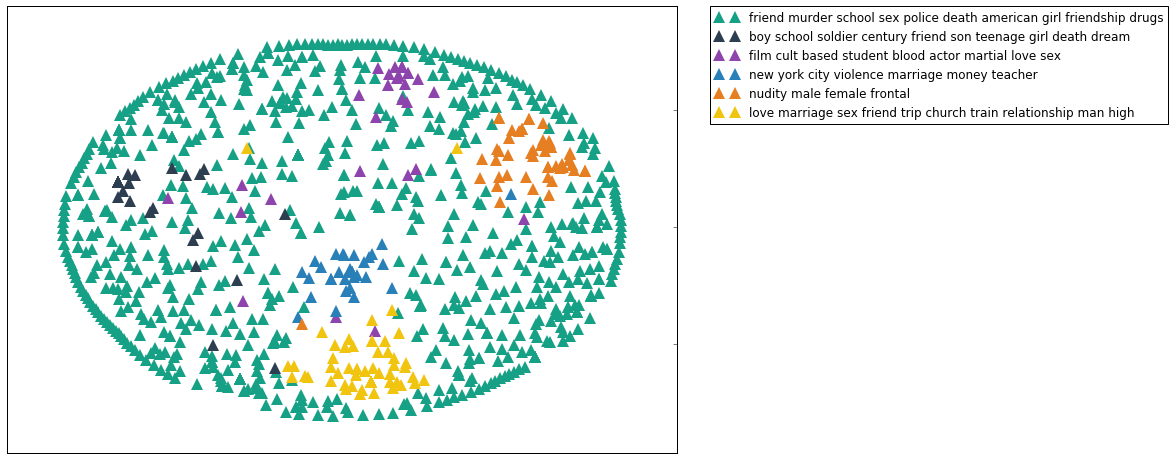

In [2]:
import nltk
from sklearn import feature_extraction
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS
import pandas as pd 
import re
import numpy as np
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

movie_df = pd.read_csv('movie_master_dataset.csv', encoding = "ISO-8859-1")

hg = movie_df.sort(['gross'], ascending = True)
hg = hg.reset_index(drop=True)
hg = hg.head(1000)

titles = list(hg['movie_title']) 
keywords = list(hg['plot_keywords'])
keywords = [key.replace('|', ' ') for key in keywords]

def unique_list(l):
    remove_list = ['box', 'office', 'flop', 'bashed', 'critically', 'title', 'word', 'character', 'scene', 'credits']
    ulist = []
    [ulist.append(x) for x in l if x not in ulist and x not in remove_list and not set('[~!@#$%^&*()_+{}":;\']+$').intersection(x)]
    return ulist

keywords = [' '.join(unique_list(key.split())) for key in keywords]

def tokenize(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,
                                 min_df=0.01, stop_words='english',
                                 use_idf=True, tokenizer=tokenize, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(keywords) 
terms = tfidf_vectorizer.get_feature_names() 

dist = 1 - cosine_similarity(tfidf_matrix)
k = 6

km = KMeans(n_clusters=k)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

#print("Top terms per cluster:")
asc_order_centroids = km.cluster_centers_.argsort()#[:, ::-1]
order_centroids = asc_order_centroids[:,::-1]
terms = tfidf_vectorizer.get_feature_names()
labels = [] 
for i in range(k):
    #print("Cluster {}:".format(i))
    temp = {i: []}
    for ind in order_centroids[i, :10]:
        temp[i].append(terms[ind])
        #print(' {}'.format(terms[ind]))
    #print('')
    labels.append(temp) 
    
words = ['', '', '', '', '', ''] 
index = 0 
for i in labels: 
    for j in i: 
        for k in range(len(i[j])): 
            if k == (len(i[j]) - 1): 
                words[index] += i[j][k]
            else: 
                words[index] += i[j][k] + ','
    index += 1 
    
clean_words = []
for word in words:
    word = word.replace(',', ' ')
    word = ' '.join(unique_list(word.split()))
    clean_words.append(word)
words = clean_words
    
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist) 
xs, ys = pos[:, 0], pos[:, 1]

# set up colors per clusters using a dict
cluster_colors = {0: '#16a085', 1: '#2c3e50', 2: '#8e44ad', 3: '#2980b9', 4: '#e67e22', 5:'#f1c40f'} 

# set up cluster names using a dict
cluster_names = {0: words[0], 
                 1: words[1], 
                 2: words[2], 
                 3: words[3], 
                 4: words[4],
                 5: words[5]
                }

df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#cluster groups 
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 8)) 
ax.margins(0.10) 

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='^', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          
        which='both',      
        bottom='off',      
        top='off',         
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         
        which='both',      
        left='off',      
        top='off',         
        labelleft='off')
    
ax.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show() 